In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [ ]:
import optuna
from keras import Model, Input, layers, optimizers, losses, metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load the data
# df = pd.read_csv('./drive/MyDrive/VagusNerveResearchProject/vns_dataset_threshold_sim.csv')

# # Transform the data
# data_ab = df.copy()
# data_ab = data_ab[data_ab['C_activation_level'] == 0.0]
# data_ab = data_ab[['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'AB_activation_level']]
# data_ab.columns = ['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'activation_level']
# data_ab['fibre_type'] = 'AB'

# # Transform the data for C fibers
# data_c = df.copy()
# data_c = data_c[data_c['AB_activation_level'] == 1.0]
# data_c = data_c[['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'C_activation_level']]
# data_c.columns = ['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'activation_level']
# data_c['fibre_type'] = 'C'

# df_transformed = pd.concat([data_ab, data_c], ignore_index=True)

# df_transformed['charge'] = df_transformed['pulse_width'] * df_transformed['amplitude']

# df_transformed.to_csv('./drive/MyDrive/VagusNerveResearchProject/vns_dataset_threshold_type.csv', index=False)

data = pd.read_csv('./drive/MyDrive/VagusNerveResearchProject/vns_dataset_threshold_type.csv')

data.loc[data['fibre_type'] == 'AB', 'fibre_type'] = 0.0
data.loc[data['fibre_type'] == 'C', 'fibre_type'] = 1.0

# Encode the categorical feature
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

X_cat = one_hot_encode(data[['fibre_type']].astype('int'), num_classes=2)
X_cat = X_cat.reshape(-1, 2)

# Split the data
X = data.loc[:, ['nerve_a', 'nerve_b', 'activation_level', 'frequency', 'pulse_width']]
X.loc[:, 'fibre_type_AB'] = X_cat[:, 0]
X.loc[:, 'fibre_type_C'] = X_cat[:, 1]
y = data.loc[:, ['amplitude']]

# X.loc[X['fibre_type'] == 'AB', 'fibre_type'] = 0
# X.loc[X['fibre_type'] == 'C', 'fibre_type'] = 1
# X.loc[:, 'fibre_type'] = pd.to_numeric(X['fibre_type'])


In [ ]:
X.head()

,nerve_a,nerve_b,activation_level,frequency,pulse_width,fibre_type_AB,fibre_type_C
0,136.8129,119.5787,0.0256,1,0.2,1.0,0.0
1,136.8129,119.5787,0.0513,1,0.2,1.0,0.0
2,136.8129,119.5787,0.0769,1,0.2,1.0,0.0
3,136.8129,119.5787,0.1026,1,0.2,1.0,0.0
4,136.8129,119.5787,0.1282,1,0.2,1.0,0.0


In [ ]:
y.head()

,amplitude
0,0.080818
1,0.083718
2,0.086135
3,0.089036
4,0.092903


In [ ]:
X_ab = X[X['fibre_type_AB'] == 1.0]
X_c = X[X['fibre_type_C'] == 1.0]
y_ab = y[X['fibre_type_AB'] == 1.0]
y_c = y[X['fibre_type_C'] == 1.0]

# Normalize the continuous features
# X_scaler = StandardScaler()
# X_norm = X_scaler.fit_transform(X[['nerve_a', 'nerve_b', 'activation_level', 'frequency', 'pulse_width']])
# y_scaler = StandardScaler()
# y_norm = y_scaler.fit_transform(y)

# X_norm = np.hstack([X_norm, X[['fibre_type_AB', 'fibre_type_C']].values])

X_scaler_ab = StandardScaler()
X_ab_norm = X_scaler_ab.fit_transform(X_ab[['nerve_a', 'nerve_b', 'activation_level', 'frequency', 'pulse_width']])
X_scaler_c = StandardScaler()
X_c_norm = X_scaler_c.fit_transform(X_c[['nerve_a', 'nerve_b', 'activation_level', 'frequency', 'pulse_width']])

y_scaler_ab = StandardScaler()
y_ab_norm = y_scaler_ab.fit_transform(y_ab)
y_scaler_c = StandardScaler()
y_c_norm = y_scaler_c.fit_transform(y_c)

X_ab_norm = np.hstack([X_ab_norm, X_ab[['fibre_type_AB', 'fibre_type_C']].values])
X_c_norm = np.hstack([X_c_norm, X_c[['fibre_type_AB', 'fibre_type_C']].values])

X_norm = np.vstack([X_ab_norm, X_c_norm])
y_norm = np.vstack([y_ab_norm, y_c_norm])

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

In [ ]:
print(X_train[:5, -2:])
print(y_train[:5])

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
[[-0.67558996]
 [ 0.28771648]
 [-0.72330342]
 [ 0.18663829]
 [-0.56343257]]


In [17]:
np.array([2, 1]).reshape(2, 1).shape

(2, 1)

In [29]:
from keras import losses
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np

def create_model(trial: optuna.Trial) -> Model:
    # Define hyperparameters
    n_layers = trial.suggest_int('n_layers', 1, 5)
    learning_rate = 0.0001
    activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'sigmoid'])

    # Input layer
    input_layer = Input(shape=(7,), name='input')
    x = input_layer

    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    use_dropout = trial.suggest_categorical('use_dropout', [True, False])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)

    # Hidden layers
    for i in range(n_layers):
        layer_size = trial.suggest_int(f'layer_size_{i}', 8, 1024)
        x = layers.Dense(layer_size, activation=(layers.LeakyReLU() if activation == 'leaky_relu' else activation))(x)
        if use_batch_norm:
            x = layers.BatchNormalization()(x)
        if use_dropout:
            x = layers.Dropout(dropout_rate)(x)

    # Output layer
    output_layer = layers.Dense(1)(x)

    def custom_loss(y_aug, y_pred):
        y_true = y_aug[:, :1]
        classes = y_aug[:, 1:]
        class_weights = tf.constant([1.0, 2.0])

        error_weights = K.dot(classes, K.expand_dims(class_weights))

        # Calculate the weighted MSE
        sq_error = (y_true - y_pred) ** 2
        weighted_mse = K.mean(error_weights * sq_error, axis=0)

        return weighted_mse


    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss=custom_loss, metrics=['mae'])

    return model

def objective(trial):
    # Create the model
    model = create_model(trial)

    # Fit the model
    history = model.fit(
        X_train,
        np.append(y_train, X_train[:, -2:], axis=1),
        validation_split=0.2,
        epochs=50,
        batch_size=64,
        verbose=0,
    )

    # Evaluate the model
    score = model.evaluate(X_test, np.append(y_test, X_test[:, -2:], axis=1), verbose=0)

    num_params = model.count_params()

    return score[0], num_params # You can also return other metrics if needed

# Create study and optimize
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler=sampler, directions=['minimize', 'minimize'])
study.optimize(objective, n_trials=50)

[I 2024-09-04 14:58:17,209] A new study created in memory with name: no-name-38499f63-4f97-4096-a9f4-14ef776e01fa
[I 2024-09-04 14:59:59,592] Trial 0 finished with values: [0.04179628938436508, 1606432.0] and parameters: {'n_layers': 5, 'activation': 'relu', 'use_batch_norm': True, 'use_dropout': False, 'dropout_rate': 0.15258482292663225, 'layer_size_0': 1010, 'layer_size_1': 856, 'layer_size_2': 667, 'layer_size_3': 172, 'layer_size_4': 200}.
[I 2024-09-04 15:01:08,169] Trial 1 finished with values: [0.07978591322898865, 2342882.0] and parameters: {'n_layers': 5, 'activation': 'relu', 'use_batch_norm': False, 'use_dropout': True, 'dropout_rate': 0.23754327451573168, 'layer_size_0': 196, 'layer_size_1': 954, 'layer_size_2': 632, 'layer_size_3': 949, 'layer_size_4': 998}.
[I 2024-09-04 15:02:13,627] Trial 2 finished with values: [0.030473968014121056, 386709.0] and parameters: {'n_layers': 5, 'activation': 'relu', 'use_batch_norm': False, 'use_dropout': False, 'dropout_rate': 0.2219026

In [ ]:
# save study
import pickle
import datetime
now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
with open(f'./drive/MyDrive/VagusNerveResearchProject/final-models/parameters-amplitude-mlp-study-{timestamp}.pkl', 'wb') as f:
    pickle.dump(study, f)

Best trials:
Trial 1:
  Value: [0.012666665017604828, 229942.0]
  Params: {'n_layers': 2, 'activation': 'relu', 'use_batch_norm': False, 'use_dropout': False, 'dropout_rate': 0.25459126973492263, 'layer_size_0': 929, 'layer_size_1': 239}
Trial 2:
  Value: [0.015421781688928604, 80329.0]
  Params: {'n_layers': 2, 'activation': 'leaky_relu', 'use_batch_norm': False, 'use_dropout': False, 'dropout_rate': 0.1000254117553058, 'layer_size_0': 164, 'layer_size_1': 476}
Trial 3:
  Value: [0.015634430572390556, 10622.0]
  Params: {'n_layers': 1, 'activation': 'relu', 'use_batch_norm': True, 'use_dropout': False, 'dropout_rate': 0.2226272100600095, 'layer_size_0': 817}
Trial 4:
  Value: [0.016836097463965416, 2705.0]
  Params: {'n_layers': 1, 'activation': 'relu', 'use_batch_norm': True, 'use_dropout': False, 'dropout_rate': 0.22251473225192547, 'layer_size_0': 208}
Trial 5:
  Value: [0.06181076169013977, 1249.0]
  Params: {'n_layers': 1, 'activation': 'leaky_relu', 'use_batch_norm': True, 'use_

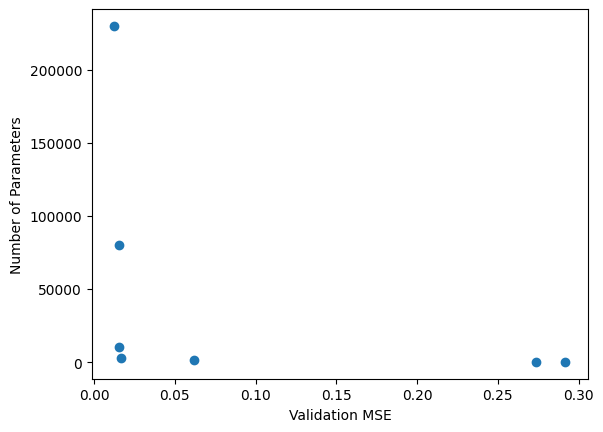

In [ ]:
import matplotlib.pyplot as plt

# Get the best hyperparameters
best_trials = study.best_trials
best_trials = sorted(best_trials, key=lambda trial: trial.values[0])

print('Best trials:')
for i, trial in enumerate(best_trials):
    print(f'Trial {i+1}:')
    print(f'  Value: {trial.values}')
    print(f'  Params: {trial.params}')

plt.figure()
plt.scatter([trial.values[0] for trial in best_trials], [trial.values[1] for trial in best_trials])
plt.xlabel('Validation MSE')
plt.ylabel('Number of Parameters')
plt.show()

In [ ]:
best_trial = best_trials[0]
best_hyperparams = best_trial.params

# Create and compile the best model
best_model = create_model(optuna.trial.FixedTrial(best_hyperparams))
best_model.summary()

# Train the best model
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
)

# Evaluate the best model
final_score = best_model.evaluate(X_test, y_test)
print(f"Final score (test MSE): {final_score[0]}")


Model: "functional_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_559 (Dense)                    │ (None, 929)                 │           7,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_560 (Dense)                    │ (None, 239)                 │         222,270 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_561 (Dense)                    │ (None, 1)                   │             240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 229,942 (898.21 KB)

 Trainable params: 229,942 (898.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5336 - mae: 0.5046 - val_loss: 0.2185 - val_mae: 0.2503
Epoch 2/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1802 - mae: 0.2488 - val_loss: 0.1127 - val_mae: 0.2034
Epoch 3/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0923 - mae: 0.1752 - val_loss: 0.0711 - val_mae: 0.1443
Epoch 4/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0550 - mae: 0.1280 - val_loss: 0.0537 - val_mae: 0.1196
Epoch 5/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0407 - mae: 0.1061 - val_loss: 0.0421 - val_mae: 0.1019
Epoch 6/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0278 - mae: 0.0848 - val_loss: 0.0427 - val_mae: 0.0947
Epoch 7/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0254 - mae: 0.0777 - val_loss: 0.0300 - val_mae: 0.0617
Epoch 8/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0214 - mae: 0.0678 - val_loss: 0.0275 - val_mae: 0.0608
Epoch 9/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

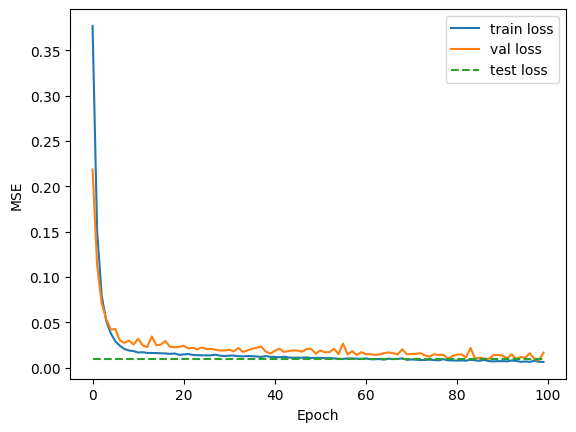

In [ ]:
# plot the training history
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.plot([final_score[0]]*len(history.history['loss']), label='test loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

In [ ]:
y_test.shape

(6482, 1)

In [ ]:
# Generate predictions
y_pred = best_model.predict(X_test)

# Inverse transform the predictions
y_pred_denorm = y_pred.copy()
y_test_denorm = y_test.copy()
y_pred_denorm[X_test[:, 5] == 1.0, :] = y_scaler_ab.inverse_transform(y_pred[X_test[:, 5] == 1.0, :])
y_test_denorm[X_test[:, 5] == 1.0, :] = y_scaler_ab.inverse_transform(y_test[X_test[:, 5] == 1.0, :])
y_pred_denorm[X_test[:, 6] == 1.0, :] = y_scaler_c.inverse_transform(y_pred[X_test[:, 6] == 1.0, :])
y_test_denorm[X_test[:, 6] == 1.0, :] = y_scaler_c.inverse_transform(y_test[X_test[:, 6] == 1.0, :])

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Text(0, 0.5, 'Predicted')

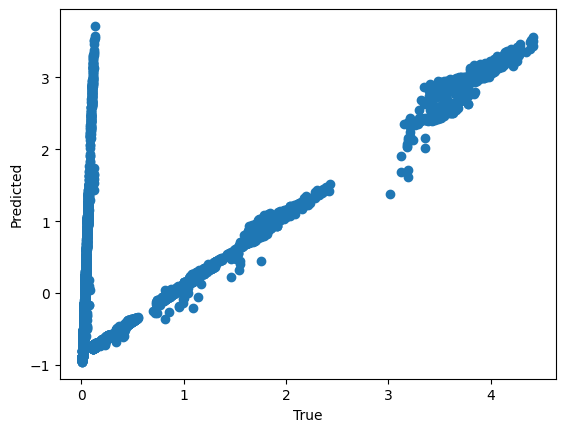

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test[:, 0], y_pred[:, 0])
plt.xlabel('True')
plt.ylabel('Predicted')

TypeError: 'Axes' object is not iterable

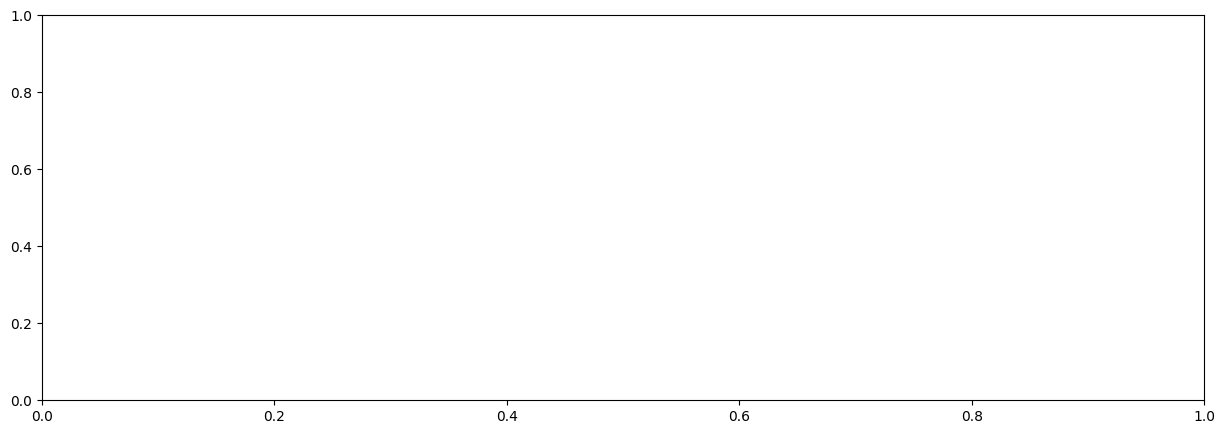

In [ ]:
# Plot the predictions for each output
params = ['amplitude', 'pulse_width']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.scatter(y_test[:, i], y_pred[:, i])
    ax.plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_pred[:, i]), max(y_pred[:, i])], linestyle='--', color='black')
    ax.set_xlabel(f'True {params[i]}')
    ax.set_ylabel(f'Predicted {params[i]}')
    ax.set_title(f'{params[i]}')


In [ ]:
with open(f'/content/drive/MyDrive/VagusNerveResearchProject/final-models/parameter-model-mlp-{timestamp}.pkl', 'wb') as f:
    pickle.dump(best_model, f)

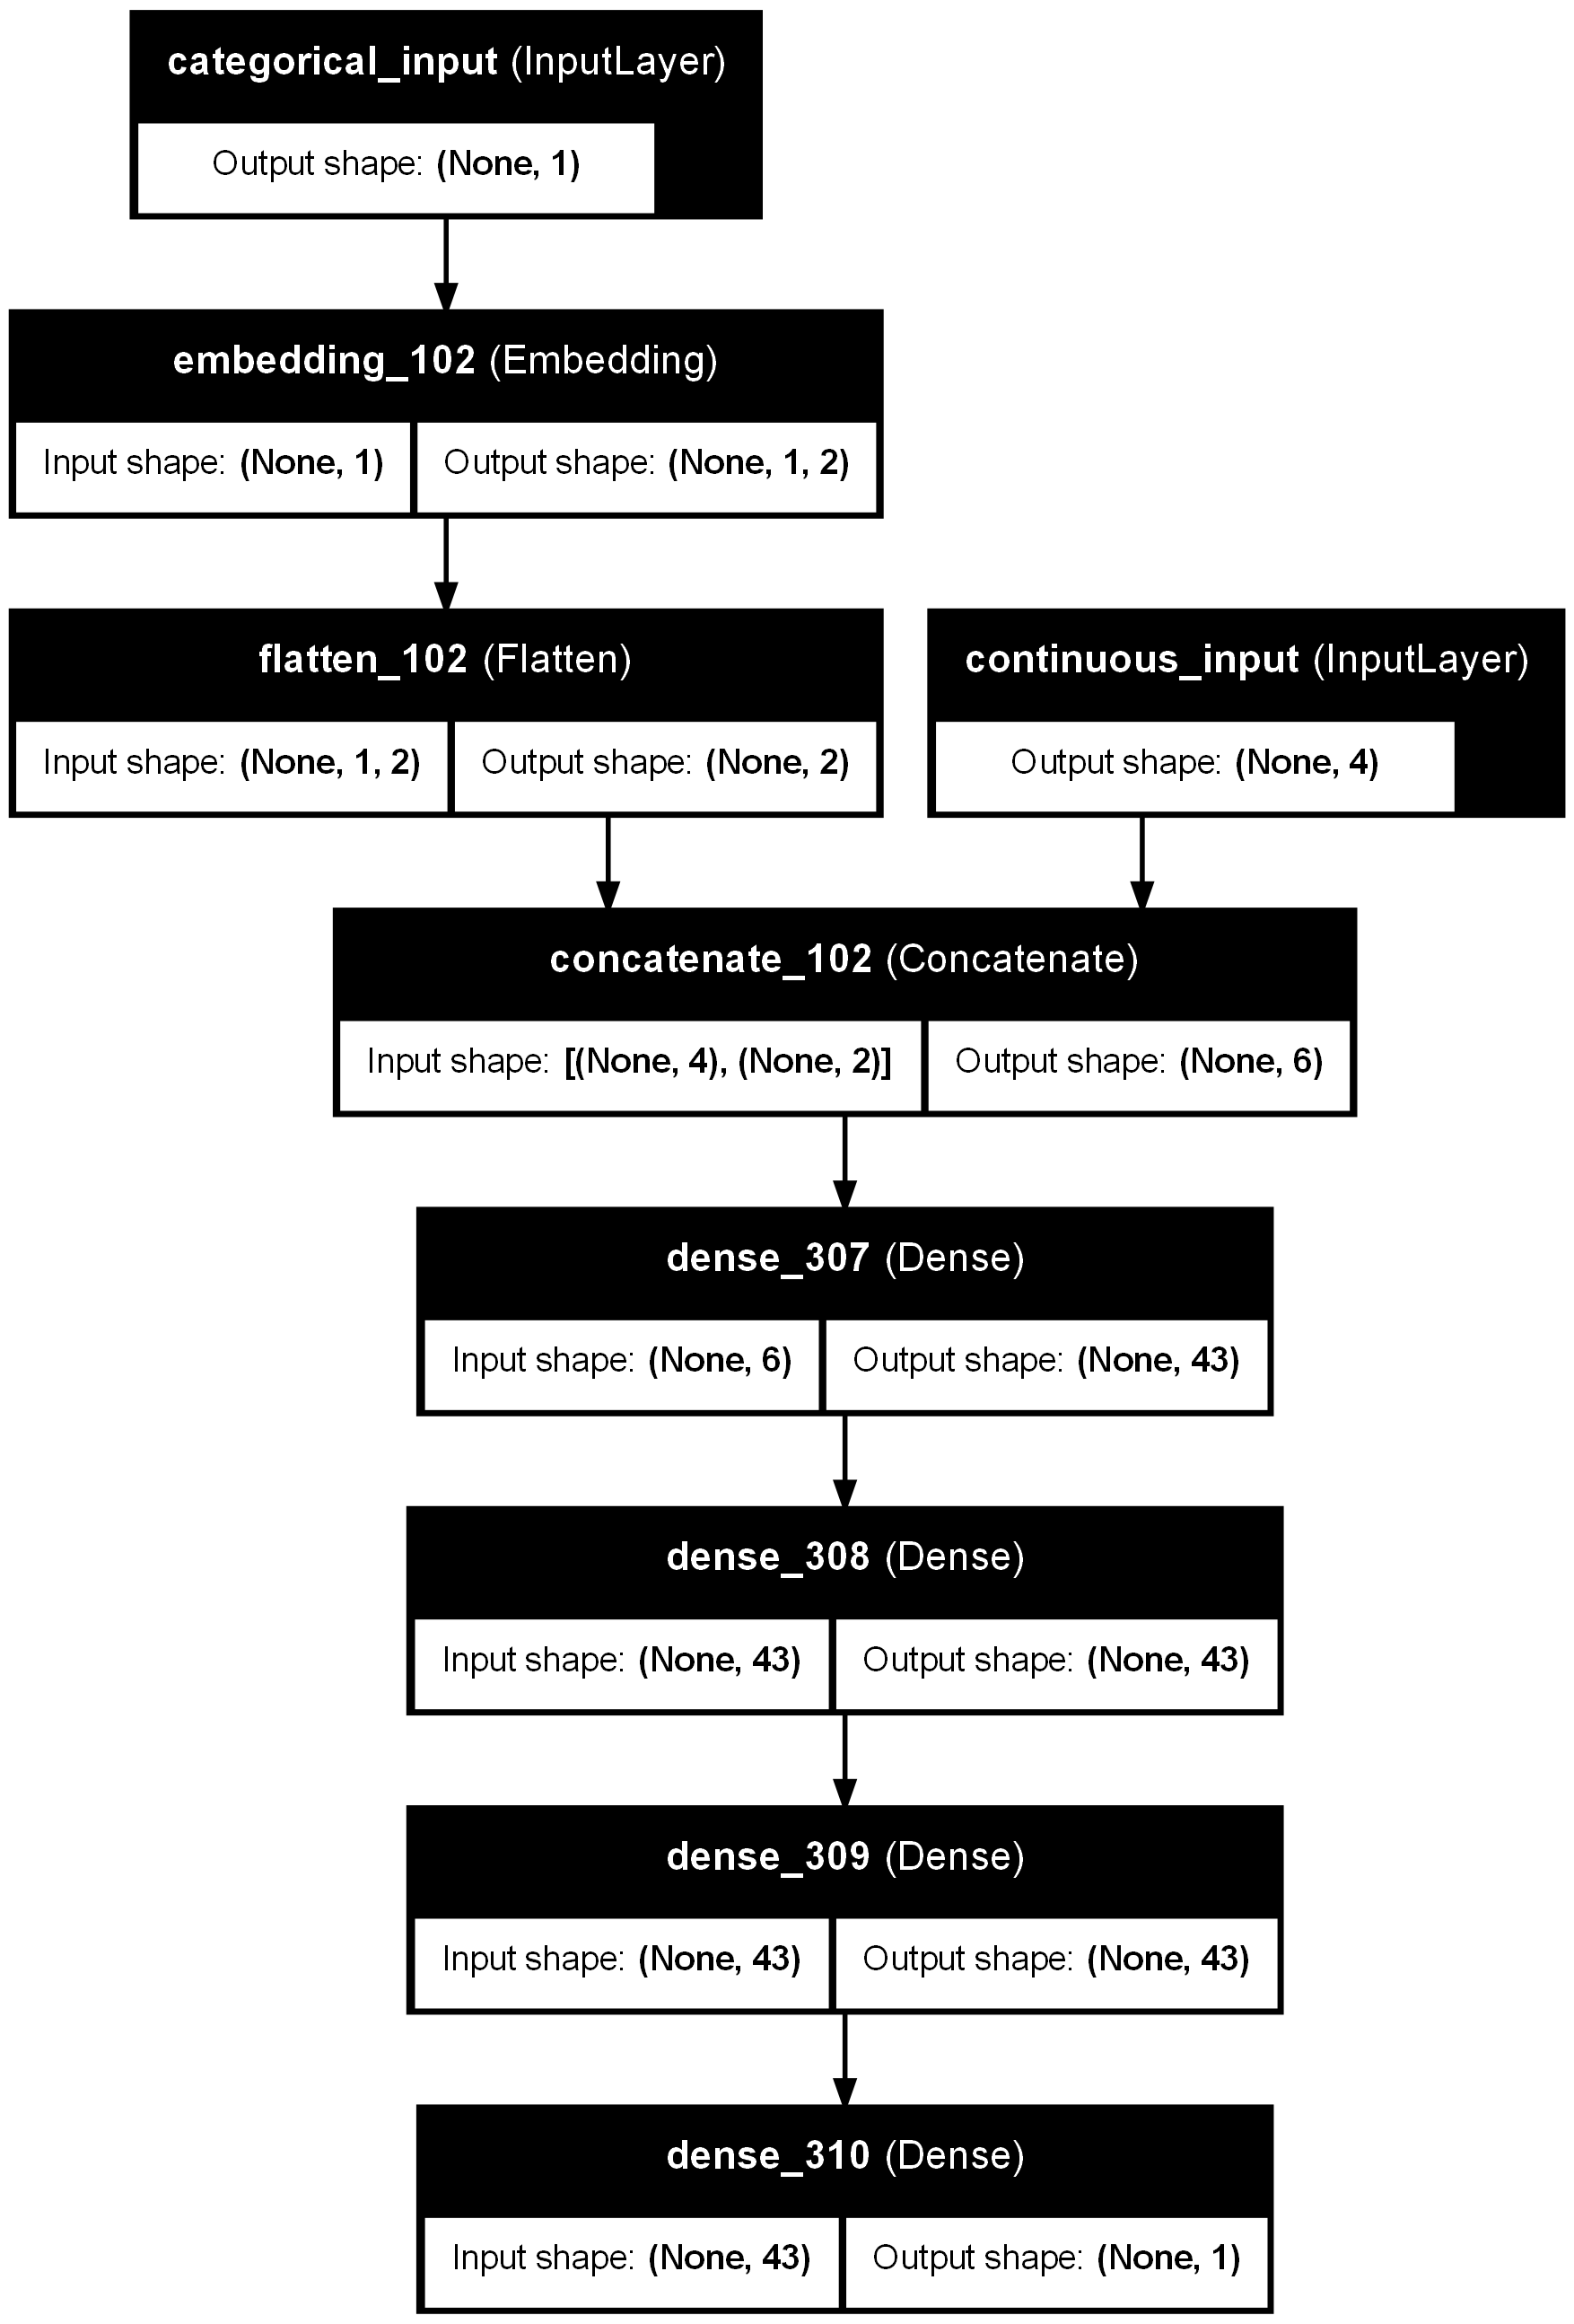

In [ ]:
from keras import utils

utils.plot_model(best_model, show_shapes=True, show_layer_names=True)

In [ ]:
# save study
import pickle

with open('./models/parameters-study.pkl', 'wb') as f:
    pickle.dump(study, f)

In [ ]:
from optuna.visualization import plot_contour

params = [
    'n_layers',
    'layer_size',
    'learning_rate'
]

plot_contour(study, target=lambda t: t.values[0], params=['n_layers', 'layer_size'])

In [ ]:
%pip install plotly

In [ ]:
# 3D scatter plot of pulse width, amplitude and activation level
import plotly.graph_objs as go
import plotly.express as px

X_test_denorm = X_test.copy()
X_test_denorm[:, :4] = scaler.inverse_transform(X_test_denorm[:, :4])

# Create the 3D scatter plot
fig = px.scatter_3d(
    x=y_pred[:, 0],
    y=y_pred[:, 1],
    z=X_test_denorm[:, 2],
    color=X_test_denorm[:, 3],
    opacity=0.6,
    color_continuous_scale='Viridis'
)

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='Amplitude',
        yaxis_title='Pulse Width',
        zaxis_title='Activation Level'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Show the plot
fig.show()